# Predição do clima

A partir da base [WEATHER PREDICTION](https://www.kaggle.com/datasets/ananthr1/weather-prediction),
disponivel no Kaggle iremos criar um modelo capaz de prever o clima apartir da entrada de algums dados

### Importando as bibliotecas necessárias

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mso
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

### Analizando os dados da base

In [51]:
# Importando a base de dados

df = pd.read_csv('seattle-weather.csv')

# Visualizando as 5 primeiras linhas

df.head(5)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [52]:
# Visualizando o tamanho da base

df.shape

(1461, 6)

/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

<Axes: xlabel='weather', ylabel='count'>

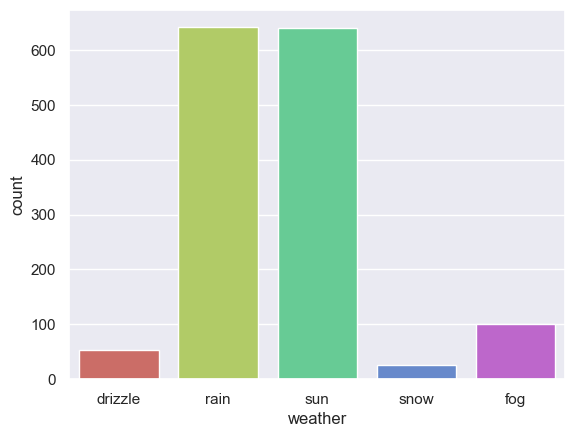

In [53]:
# Visualizando como estão distribuídos os dados

sns.countplot(x=df["weather"], palette="hls")

In [54]:
# Calculando como os atributos estão distribuidos

countrain=len(df[df.weather=="rain"])
countsun=len(df[df.weather=="sun"])
countdrizzle=len(df[df.weather=="drizzle"])
countsnow=len(df[df.weather=="snow"])
countfog=len(df[df.weather=="fog"])

print("Porcentagem de Rain: {:2f}%".format((countrain/(len(df.weather))*100)))
print("Porcentagem de Sun: {:2f}%".format((countsun/(len(df.weather))*100)))
print("Porcentagem de Drizzle: {:2f}%".format((countdrizzle/(len(df.weather))*100)))
print("Porcentagem de Snow: {:2f}%".format((countsnow/(len(df.weather))*100)))
print("Porcentagem de Fog: {:2f}%".format((countfog/(len(df.weather))*100)))

Porcentagem de Rain: 43.874059%
Porcentagem de Sun: 43.805613%
Porcentagem de Drizzle: 3.627652%
Porcentagem de Snow: 1.779603%
Porcentagem de Fog: 6.913073%


### Explorando qual é o tipo dos dados

In [55]:
# Visualizando as estatísticas dos atributos

df[["precipitation","temp_max","temp_min","wind"]].describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.

<Axes: xlabel='wind', ylabel='Count'>

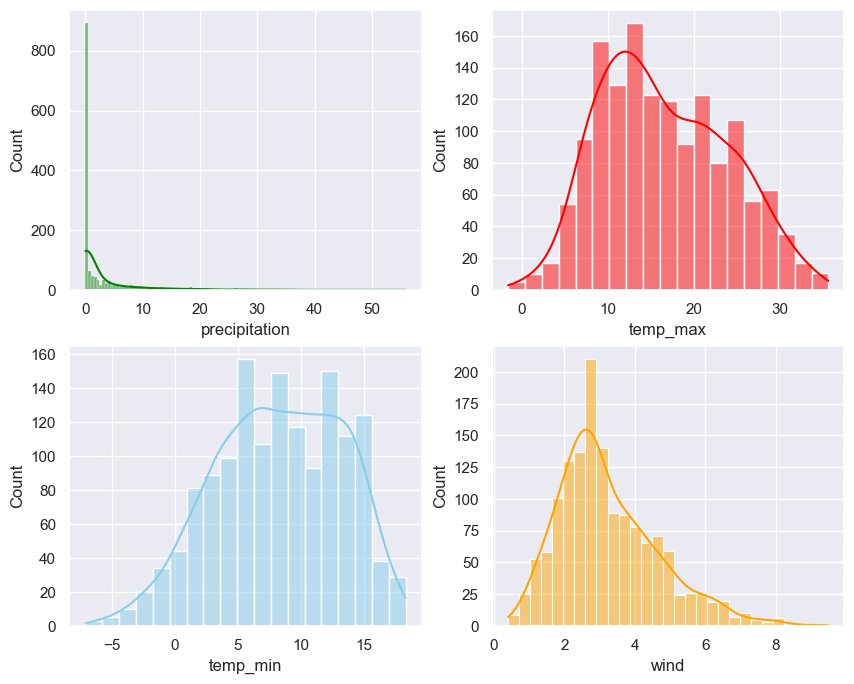

In [56]:
# Visualizando como estão distribuídos os dados de cada atributo

sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=df,x="precipitation",kde=True,ax=axs[0,0],color='green')
sns.histplot(data=df,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.histplot(data=df,x="temp_min",kde=True,ax=axs[1,0],color='skyblue')
sns.histplot(data=df,x="wind",kde=True,ax=axs[1,1],color='orange')

### Verificando se a base possui dados ausentes

In [57]:
# Visualizando a quantidade de valores ausentes em cada atributo

df.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

<Axes: >

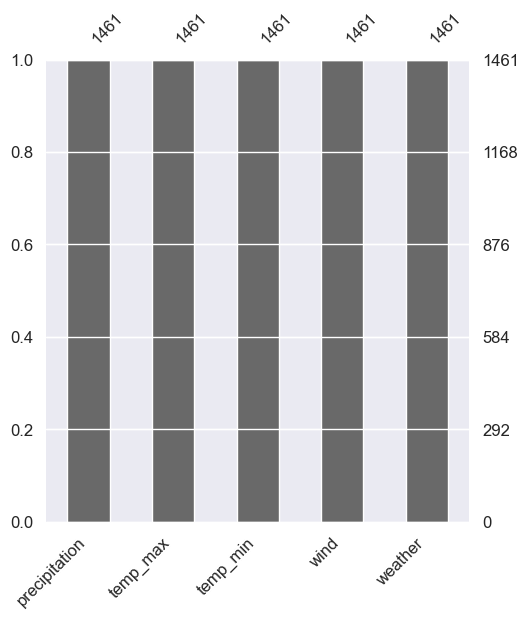

In [58]:
# Visualizando a proporção de valores ausentes em cada atributo

plt.figure(figsize=(12,6))
axz = plt.subplot(1,2,2)
mso.bar(df.drop(["date"],axis=1), ax=axz, fontsize=12)

In [59]:
# Pelo que foi mostrado, não há valores ausentes na base

#### Pré-processamento da base

In [60]:
# Removendo os atributos desnecessários

df = df.drop(["date"], axis=1)
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,drizzle
1,10.9,10.6,2.8,4.5,rain
2,0.8,11.7,7.2,2.3,rain
3,20.3,12.2,5.6,4.7,rain
4,1.3,8.9,2.8,6.1,rain


In [61]:
# Codificando os atributos categóricos

lc=LabelEncoder()
df["weather"]=lc.fit_transform(df["weather"])

df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,0
1,10.9,10.6,2.8,4.5,2
2,0.8,11.7,7.2,2.3,2
3,20.3,12.2,5.6,4.7,2
4,1.3,8.9,2.8,6.1,2


In [62]:
# Separendo os atributos de entrada e classificação

x=((df.loc[:,df.columns!="weather"]).astype(int)).values[:,0:]
y=df["weather"].values

df.weather.unique()

array([0, 2, 4, 3, 1])

In [68]:
# Separando os dados de treino e teste

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

print(x_train.shape)
print(x_test.shape)

(1168, 4)
(293, 4)


### Encontrando os melhores hiperparametros

In [64]:
# Definindo os hiperparametros que serão testados para cada modelo

random_params = {
    'max_depth': [3,5,10,None],
    'n_estimators': [10,100,200,300,400,500,600,700,800,900,1000],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'criterion': ['gini','entropy'],
    'bootstrap': [True,False],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
}

tree_params = {
    'max_depth': [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
    'criterion': ['gini','entropy', 'log_loss'],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
}

NB_params = {
    'var_smoothing': np.logspace(0, -9, num=100),
}

bagging_models_to_test = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB(),
]

bagging_params = {
    'estimator': bagging_models_to_test,
    'n_estimators': np.arange(10, 200, 10),
    'max_samples': np.linspace(0.1, 1.0, 10),
    'max_features': np.linspace(0.1, 1.0, 10),
    'bootstrap_features': [True,False],
    'oob_score': [True,False],
    'n_jobs': [-1],
    'random_state': list(range(0, 43)),
}

XGB_params = {
    'n_estimators': np.arange(100, 1000, 100),
    'learning_rate': [0.01, 0.1, 0.2, 0.3], 
    'max_depth': np.arange(3, 10),            
    'min_child_weight': np.arange(1, 6),       
    'subsample': np.linspace(0.6, 1.0, 5),     
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
}


In [65]:
# Obtendo os melhores hiperparametros para cada modelo

tree_model = DecisionTreeClassifier()
RS_tree = RandomizedSearchCV(tree_model, param_distributions=tree_params, n_iter=20, cv=10, error_score='raise', n_jobs=-1)
RS_tree.fit(x_train, y_train)
best_tree = RS_tree.best_estimator_
print("Best Tree Params: ", RS_tree.best_params_)
print("Best Tree Score: ", RS_tree.best_score_)

random_model = RandomForestClassifier()
RS_random = RandomizedSearchCV(random_model, param_distributions=random_params, n_iter=20, cv=10, error_score='raise', n_jobs=-1)
RS_random.fit(x_train, y_train)
best_random = RS_random.best_estimator_
print("Best Random Params: ", RS_random.best_params_)
print("Best Random Score: ", RS_random.best_score_)

NB_model = GaussianNB()
RS_nb = RandomizedSearchCV(NB_model, param_distributions=NB_params, n_iter=20, cv=10, error_score='raise', n_jobs=-1)
RS_nb.fit(x_train, y_train)
best_NB = RS_nb.best_estimator_
print("Best NB Params: ", RS_nb.best_params_)
print("Best NB Score: ", RS_nb.best_score_)

XGB_model = XGBClassifier()
RS_xgb = RandomizedSearchCV(XGB_model, param_distributions=XGB_params, n_iter=20, cv=10, error_score='raise', n_jobs=-1)
RS_xgb.fit(x_train, y_train)
best_XGB = RS_xgb.best_estimator_
print("Best XGB Params: ", RS_xgb.best_params_)
print("Best XGB Score: ", RS_xgb.best_score_)

bagging_model = BaggingClassifier()
RS_bagging = RandomizedSearchCV(bagging_model, param_distributions=bagging_params, n_iter=20, cv=10, error_score='raise', n_jobs=-1)
RS_bagging.fit(x_train, y_train)
best_bagging = RS_bagging.best_estimator_
print("Best Bagging Params: ", RS_bagging.best_params_)
print("Best Bagging Score: ", RS_bagging.best_score_)


Best Tree Params:  {'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.8, 'max_depth': 4, 'criterion': 'log_loss'}
Best Tree Score:  0.7799734748010609
Best Random Params:  {'n_estimators': 700, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
Best Random Score:  0.7928455643972886
Best NB Params:  {'var_smoothing': 1.519911082952933e-07}
Best NB Score:  0.7765620394930739
Best XGB Params:  {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best XGB Score:  0.7894267609784851


/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Bagging Params:  {'random_state': 26, 'oob_score': False, 'n_jobs': -1, 'n_estimators': 120, 'max_samples': 0.4, 'max_features': 0.9, 'estimator': RandomForestClassifier(), 'bootstrap_features': False}
Best Bagging Score:  0.7816902446212791


### Testando os modelos

/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.uniqu

<Axes: >

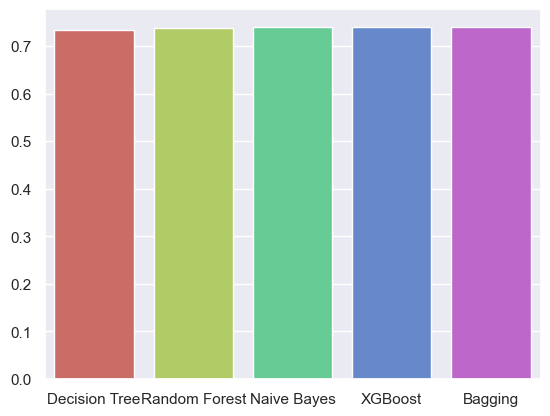

In [66]:
# Acuracia dos modelos

tree_pred = best_tree.predict(x_test)
random_pred = best_random.predict(x_test)
NB_pred = best_NB.predict(x_test)
XGB_pred = best_XGB.predict(x_test)
bagging_pred = best_bagging.predict(x_test)

scores = [accuracy_score(y_test, tree_pred), accuracy_score(y_test, random_pred), accuracy_score(y_test, NB_pred), accuracy_score(y_test, XGB_pred), accuracy_score(y_test, bagging_pred)]
model_names = ['Decision Tree', 'Random Forest', 'Naive Bayes', 'XGBoost', 'Bagging']

sns.barplot(x=model_names, y=scores, palette="hls")

In [71]:
# Classification Report

print("Decision Tree:")
print(classification_report(y_test,tree_pred))
print("Random Forest:")
print(classification_report(y_test,random_pred))
print("Naive Bayes:")
print(classification_report(y_test,NB_pred))
print("XGBoost:")
print(classification_report(y_test,XGB_pred))
print("Bagging:")
print(classification_report(y_test,bagging_pred))

Decision Tree:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        25
           2       0.39      0.31      0.35       120
           3       0.00      0.00      0.00         8
           4       0.45      0.68      0.54       131

    accuracy                           0.43       293
   macro avg       0.17      0.20      0.18       293
weighted avg       0.36      0.43      0.38       293

Random Forest:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        25
           2       0.37      0.36      0.37       120
           3       0.00      0.00      0.00         8
           4       0.43      0.56      0.49       131

    accuracy                           0.40       293
   macro avg       0.16      0.18      0.17       293
weighted avg       0.34      0.40      0.37    

/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision 

/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/Documentos/PUC-Minas_Backup/Ciência da Computação/Graduating/4°Período/IA/TP1/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision 

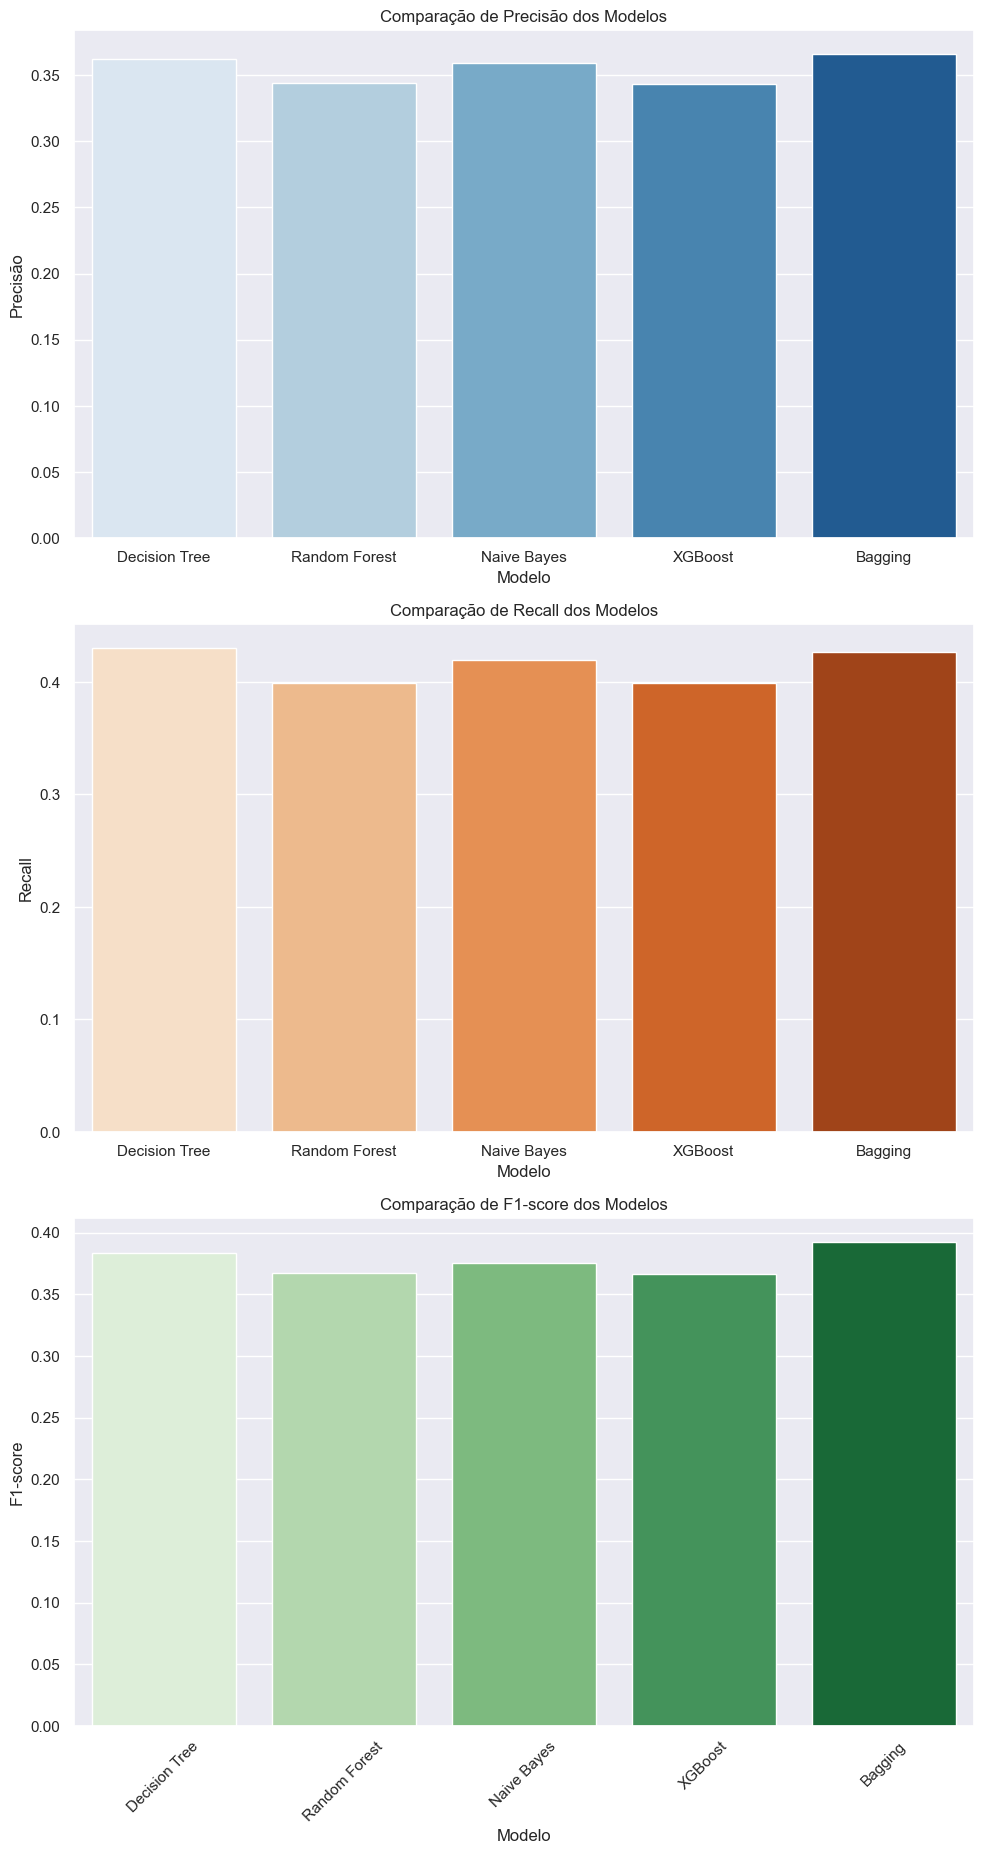

In [75]:
results = {
    'Modelo': ['Decision Tree', 'Random Forest', 'Naive Bayes', 'XGBoost', 'Bagging'],
    'Precisão': [
        classification_report(y_test, tree_pred, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, random_pred, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, NB_pred, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, XGB_pred, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, bagging_pred, output_dict=True)['weighted avg']['precision']
    ],
    'Recall': [
        classification_report(y_test, tree_pred, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, random_pred, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, NB_pred, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, XGB_pred, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, bagging_pred, output_dict=True)['weighted avg']['recall']
    ],
    'F1-score': [
        classification_report(y_test, tree_pred, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, random_pred, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, NB_pred, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, XGB_pred, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, bagging_pred, output_dict=True)['weighted avg']['f1-score']
    ]
}

# Criar um DataFrame a partir do dicionário
df = pd.DataFrame(results)

# Criar gráficos separados para cada métrica usando subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Gráfico para Precisão
sns.barplot(x='Modelo', y='Precisão', data=df, palette='Blues', ax=axes[0])
axes[0].set_ylabel('Precisão')
axes[0].set_title('Comparação de Precisão dos Modelos')

# Gráfico para Recall
sns.barplot(x='Modelo', y='Recall', data=df, palette='Oranges', ax=axes[1])
axes[1].set_ylabel('Recall')
axes[1].set_title('Comparação de Recall dos Modelos')

# Gráfico para F1-score
sns.barplot(x='Modelo', y='F1-score', data=df, palette='Greens', ax=axes[2])
axes[2].set_ylabel('F1-score')
axes[2].set_title('Comparação de F1-score dos Modelos')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()